# MNIST CNN classifier

### Imports and setup

In [1]:
import torchvision
import torch
%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

In [2]:
USE_GPU = True
NUM_EPOCHS = 20
DATA_ROOT = "/data/liveproject-melanoma/"
BATCH_SIZE = 100

In [3]:
if USE_GPU: 
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
else:
    device = "cpu"

print(device)

cuda:0


### Datasets

In [4]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307), (0.3081)) # mean and standard deviation of MNIST training dataset
    ]
)

In [5]:
train_dataset = torchvision.datasets.MNIST(DATA_ROOT, download=True, train=True, transform=transform)
test_dataset  = torchvision.datasets.MNIST(DATA_ROOT, download=True, train=False, transform=transform)

In [6]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: /data/liveproject-melanoma/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.1307, std=0.3081)
           )

In [7]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: /data/liveproject-melanoma/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.1307, std=0.3081)
           )

In [8]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

### CNN Setup

In [9]:
relu = torch.nn.functional.relu

class Net(torch.nn.Module):    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5)
        self.l1 = torch.nn.Linear(in_features=16 * 16, out_features=32)
        self.l2 = torch.nn.Linear(in_features=32, out_features=16)
        self.l3 = torch.nn.Linear(in_features=16, out_features=10)

    def forward(self, x):
        x = self.pool(relu(self.conv1(x)))
        x = self.pool(relu(self.conv2(x)))
        x = x.view(BATCH_SIZE, -1)
        x = relu(self.l1(x))
        x = relu(self.l2(x))
        x = self.l3(x)
        
        return x

net = Net()
net = net.to(device)

In [10]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Training

In [11]:
num_training_samples = len(train_dataloader)
epoch_losses = []

for epoch in range(NUM_EPOCHS):
    print('Epoch %d...' % (epoch + 1))
    
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataloader)
    epoch_losses.append(epoch_loss)

print('Finished Training')

Epoch 1...
Epoch 2...
Epoch 3...
Epoch 4...
Epoch 5...
Epoch 6...
Epoch 7...
Epoch 8...
Epoch 9...
Epoch 10...
Epoch 11...
Epoch 12...
Epoch 13...
Epoch 14...
Epoch 15...
Epoch 16...
Epoch 17...
Epoch 18...
Epoch 19...
Epoch 20...
Finished Training


In [12]:
torch.save(net.state_dict(), "./trained.pth")

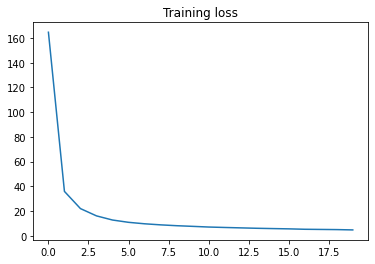

In [13]:
plt.title('Training loss')
plt.plot(epoch_losses)

### Testing

In [14]:
all_labels = []
all_predicted_labels = []

for test_sample in test_dataloader:
    inputs, labels = test_sample[0].to(device), test_sample[1]
    outputs = net(inputs).detach().cpu()
    predicted_labels = numpy.argmax(outputs, axis=1)
    all_labels = numpy.append(all_labels, labels)
    all_predicted_labels = numpy.append(all_predicted_labels, predicted_labels)

### Metrics

In [15]:
correct_count = (all_labels == all_predicted_labels).sum()
correct_ratio = correct_count / len(test_dataset)
print('Test accuracy: %.2f%%' % (correct_ratio * 100))

Test accuracy: 98.53%


[[ 975    0    0    0    0    0    1    1    2    1]
 [   0 1130    2    1    0    0    0    1    1    0]
 [   5    1 1017    0    2    0    2    3    2    0]
 [   2    1    4  993    0    4    0    2    3    1]
 [   0    0    0    0  975    0    2    1    1    3]
 [   3    0    0    7    0  874    4    1    3    0]
 [   5    3    1    0    2    2  945    0    0    0]
 [   1    1    9    2    0    0    0 1006    1    8]
 [   5    0    2    2    2    0    2    3  954    4]
 [   5    3    1    2    5    1    0    5    3  984]]


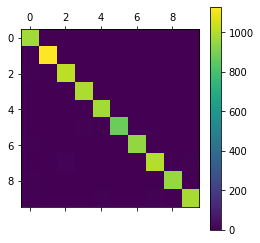

In [16]:
confusion_matrix = metrics.confusion_matrix(all_labels, all_predicted_labels, labels=list(range(10)))
print(confusion_matrix)
plt.matshow(confusion_matrix)
plt.colorbar()
plt.show()

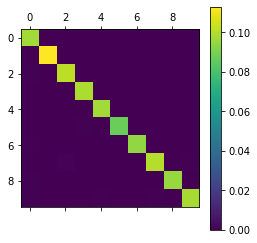

In [17]:
normalised_confusion_matrix = metrics.confusion_matrix(all_labels, all_predicted_labels, normalize='all')
plt.matshow(normalised_confusion_matrix)
plt.colorbar()
plt.show()